In [1]:
from imblearn.over_sampling import ADASYN, SMOTENC
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import (train_test_split, 
    ShuffleSplit, cross_val_score, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import (DecisionTreeClassifier, 
    ExtraTreeClassifier)
from sklearn.ensemble import (RandomForestClassifier, 
    GradientBoostingClassifier)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score)

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sn
import shap as sh

pd.set_option('display.max_columns', None)
sh.initjs()

%matplotlib inline

In [2]:
data_dir_path = "../data/fraud_oracle.csv"
df = pd.read_csv(data_dir_path, dtype=object)
print(df.shape)
df.head()

(15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


----
### Data Preprocessing

In [3]:
#convert the the columns to their proper datatypes
df["Month"] = pd.to_datetime(
    df["Month"], format="%b", errors="coerce")\
    .dt.strftime("%m") + df["Month"]
df["MonthClaimed"] = pd.to_datetime(
    df["MonthClaimed"], format="%b", errors="coerce")\
    .dt.strftime("%m") + df["MonthClaimed"]

numeric_cols = [
    "Age",
    "Deductible",
    "DriverRating",
    "RepNumber",
    "FraudFound_P"
    ]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col])

print(df.shape)
df.head()

(15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,12Dec,5,Wednesday,Honda,Urban,Tuesday,01Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,01Jan,3,Wednesday,Honda,Urban,Monday,01Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,10Oct,5,Friday,Honda,Urban,Thursday,11Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,06Jun,2,Saturday,Toyota,Rural,Friday,07Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,01Jan,5,Monday,Honda,Urban,Tuesday,02Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [4]:
#set the modelling parameters
fraud_col = "FraudFound_P"

#numerical features
num_feats = [
    'Age',
]
#categorical features
cat_feats = [
    "Month",
    "WeekOfMonth",
    "DayOfWeek", 
    "Make",
    "AccidentArea",
    "DayOfWeekClaimed",
    "MonthClaimed",
    "WeekOfMonthClaimed",
    "Sex",
    'MaritalStatus', 
    'Fault', 
    'PolicyType', 
    'VehicleCategory',
    'VehiclePrice',  
    'RepNumber',
    'DriverRating', 
    'Days_Policy_Accident',
    'Days_Policy_Claim', 
    'PastNumberOfClaims', 
    'AgeOfVehicle',
    'AgeOfPolicyHolder', 
    'PoliceReportFiled', 
    'WitnessPresent', 
    'AgentType',
    'NumberOfSuppliments',
    'AddressChange_Claim', 
    'NumberOfCars', 
    'Year',
    'BasePolicy'
]

In [5]:
#check for null values
rows_with_null = df[cat_feats].isnull().any(axis=1)
print(
    "Number of rows with null features", rows_with_null.sum())
df.loc[rows_with_null]

Number of rows with null features 1


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
1516,07Jul,2,Monday,Honda,Rural,0,NaN,1,Male,Single,0,Policy Holder,Sedan - All Perils,Sedan,more than 69000,0,1517,15,400,2,more than 30,none,none,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils


In [6]:
#drop the rows with null feature values
df = df.dropna().reset_index(drop=True)
print(df.shape)
df.head()

(15419, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,12Dec,5,Wednesday,Honda,Urban,Tuesday,01Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,01Jan,3,Wednesday,Honda,Urban,Monday,01Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,10Oct,5,Friday,Honda,Urban,Thursday,11Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,06Jun,2,Saturday,Toyota,Rural,Friday,07Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,01Jan,5,Monday,Honda,Urban,Tuesday,02Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [7]:
#mapping of categorical feature to label binarizer
cat_feat_2_lab_bin = {}
prep_df = pd.DataFrame([])

for feat_col in cat_feats:
    lb = LabelBinarizer()
    lb.fit(df[feat_col])
    if len(lb.classes_) > 2:
        columns = [feat_col + "_" + str(col_val) 
                   for col_val in lb.classes_]
    else:
        columns = [feat_col + "_" + str(col_val) 
                   for col_val in lb.classes_[:-1]]
    feat_df = pd.DataFrame(
        lb.transform(df[feat_col]),
        columns=columns)
    prep_df = pd.concat([prep_df, feat_df], axis=1)
    cat_feat_2_lab_bin[feat_col] = lb
    
print(prep_df.shape)
prep_df.head()

(15419, 164)


,Month_01Jan,Month_02Feb,Month_03Mar,Month_04Apr,Month_05May,Month_06Jun,Month_07Jul,Month_08Aug,Month_09Sep,Month_10Oct,Month_11Nov,Month_12Dec,WeekOfMonth_1,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Make_Accura,Make_BMW,Make_Chevrolet,Make_Dodge,Make_Ferrari,Make_Ford,Make_Honda,Make_Jaguar,Make_Lexus,Make_Mazda,Make_Mecedes,Make_Mercury,Make_Nisson,Make_Pontiac,Make_Porche,Make_Saab,Make_Saturn,Make_Toyota,Make_VW,AccidentArea_Rural,DayOfWeekClaimed_Friday,DayOfWeekClaimed_Monday,DayOfWeekClaimed_Saturday,DayOfWeekClaimed_Sunday,DayOfWeekClaimed_Thursday,DayOfWeekClaimed_Tuesday,DayOfWeekClaimed_Wednesday,MonthClaimed_01Jan,MonthClaimed_02Feb,MonthClaimed_03Mar,MonthClaimed_04Apr,MonthClaimed_05May,MonthClaimed_06Jun,MonthClaimed_07Jul,MonthClaimed_08Aug,MonthClaimed_09Sep,MonthClaimed_10Oct,MonthClaimed_11Nov,MonthClaimed_12Dec,WeekOfMonthClaimed_1,WeekOfMonthClaimed_2,WeekOfMonthClaimed_3,WeekOfMonthClaimed_4,WeekOfMonthClaimed_5,Sex_Female,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,Fault_Policy Holder,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,VehiclePrice_20000 to 29000,VehiclePrice_30000 to 39000,VehiclePrice_40000 to 59000,VehiclePrice_60000 to 69000,VehiclePrice_less than 20000,VehiclePrice_more than 69000,RepNumber_1,RepNumber_2,RepNumber_3,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,RepNumber_10,RepNumber_11,RepNumber_12,RepNumber_13,RepNumber_14,RepNumber_15,RepNumber_16,DriverRating_1,DriverRating_2,DriverRating_3,DriverRating_4,Days_Policy_Accident_1 to 7,Days_Policy_Accident_15 to 30,Days_Policy_Accident_8 to 15,Days_Policy_Accident_more than 30,Days_Policy_Accident_none,Days_Policy_Claim_15 to 30,Days_Policy_Claim_8 to 15,Days_Policy_Claim_more than 30,PastNumberOfClaims_1,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,AgeOfVehicle_2 years,AgeOfVehicle_3 years,AgeOfVehicle_4 years,AgeOfVehicle_5 years,AgeOfVehicle_6 years,AgeOfVehicle_7 years,AgeOfVehicle_more than 7,AgeOfVehicle_new,AgeOfPolicyHolder_16 to 17,AgeOfPolicyHolder_18 to 20,AgeOfPolicyHolder_21 to 25,AgeOfPolicyHolder_26 to 30,AgeOfPolicyHolder_31 to 35,AgeOfPolicyHolder_36 to 40,AgeOfPolicyHolder_41 to 50,AgeOfPolicyHolder_51 to 65,AgeOfPolicyHolder_over 65,PoliceReportFiled_No,WitnessPresent_No,AgentType_External,NumberOfSuppliments_1 to 2,NumberOfSuppliments_3 to 5,NumberOfSuppliments_more than 5,NumberOfSuppliments_none,AddressChange_Claim_1 year,AddressChange_Claim_2 to 3 years,AddressChange_Claim_4 to 8 years,AddressChange_Claim_no change,AddressChange_Claim_under 6 months,NumberOfCars_1 vehicle,NumberOfCars_2 vehicles,NumberOfCars_3 to 4,NumberOfCars_5 to 8,NumberOfCars_more than 8,Year_1994,Year_1995,Year_1996,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,

In [8]:
#append the numerical features and the target variable
prep_df = pd.concat(
    [prep_df, df[num_feats], df[fraud_col]], axis=1)
print(prep_df.shape)
prep_df.head()

(15419, 166)


,Month_01Jan,Month_02Feb,Month_03Mar,Month_04Apr,Month_05May,Month_06Jun,Month_07Jul,Month_08Aug,Month_09Sep,Month_10Oct,Month_11Nov,Month_12Dec,WeekOfMonth_1,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Make_Accura,Make_BMW,Make_Chevrolet,Make_Dodge,Make_Ferrari,Make_Ford,Make_Honda,Make_Jaguar,Make_Lexus,Make_Mazda,Make_Mecedes,Make_Mercury,Make_Nisson,Make_Pontiac,Make_Porche,Make_Saab,Make_Saturn,Make_Toyota,Make_VW,AccidentArea_Rural,DayOfWeekClaimed_Friday,DayOfWeekClaimed_Monday,DayOfWeekClaimed_Saturday,DayOfWeekClaimed_Sunday,DayOfWeekClaimed_Thursday,DayOfWeekClaimed_Tuesday,DayOfWeekClaimed_Wednesday,MonthClaimed_01Jan,MonthClaimed_02Feb,MonthClaimed_03Mar,MonthClaimed_04Apr,MonthClaimed_05May,MonthClaimed_06Jun,MonthClaimed_07Jul,MonthClaimed_08Aug,MonthClaimed_09Sep,MonthClaimed_10Oct,MonthClaimed_11Nov,MonthClaimed_12Dec,WeekOfMonthClaimed_1,WeekOfMonthClaimed_2,WeekOfMonthClaimed_3,WeekOfMonthClaimed_4,WeekOfMonthClaimed_5,Sex_Female,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,Fault_Policy Holder,PolicyType_Sedan - All Perils,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Sport - Liability,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,VehiclePrice_20000 to 29000,VehiclePrice_30000 to 39000,VehiclePrice_40000 to 59000,VehiclePrice_60000 to 69000,VehiclePrice_less than 20000,VehiclePrice_more than 69000,RepNumber_1,RepNumber_2,RepNumber_3,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,RepNumber_10,RepNumber_11,RepNumber_12,RepNumber_13,RepNumber_14,RepNumber_15,RepNumber_16,DriverRating_1,DriverRating_2,DriverRating_3,DriverRating_4,Days_Policy_Accident_1 to 7,Days_Policy_Accident_15 to 30,Days_Policy_Accident_8 to 15,Days_Policy_Accident_more than 30,Days_Policy_Accident_none,Days_Policy_Claim_15 to 30,Days_Policy_Claim_8 to 15,Days_Policy_Claim_more than 30,PastNumberOfClaims_1,PastNumberOfClaims_2 to 4,PastNumberOfClaims_more than 4,PastNumberOfClaims_none,AgeOfVehicle_2 years,AgeOfVehicle_3 years,AgeOfVehicle_4 years,AgeOfVehicle_5 years,AgeOfVehicle_6 years,AgeOfVehicle_7 years,AgeOfVehicle_more than 7,AgeOfVehicle_new,AgeOfPolicyHolder_16 to 17,AgeOfPolicyHolder_18 to 20,AgeOfPolicyHolder_21 to 25,AgeOfPolicyHolder_26 to 30,AgeOfPolicyHolder_31 to 35,AgeOfPolicyHolder_36 to 40,AgeOfPolicyHolder_41 to 50,AgeOfPolicyHolder_51 to 65,AgeOfPolicyHolder_over 65,PoliceReportFiled_No,WitnessPresent_No,AgentType_External,NumberOfSuppliments_1 to 2,NumberOfSuppliments_3 to 5,NumberOfSuppliments_more than 5,NumberOfSuppliments_none,AddressChange_Claim_1 year,AddressChange_Claim_2 to 3 years,AddressChange_Claim_4 to 8 years,AddressChange_Claim_no change,AddressChange_Claim_under 6 months,NumberOfCars_1 vehicle,NumberOfCars_2 vehicles,NumberOfCars_3 to 4,NumberOfCars_5 to 8,NumberOfCars_more than 8,Year_1994,Year_1995,Year_1996,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability,Age,FraudFound_P
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,21,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,34,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1

In [9]:
#show the distribution of frauds and non-frauds
pd.concat([
    df[fraud_col].value_counts().rename("fraud_counts"),
    df[fraud_col].value_counts(
        normalize=True).rename("fraud_counts_prcnt")],
    axis=1)

,fraud_counts,fraud_counts_prcnt
0,14496,0.940139
1,923,0.059861


----
### Train and Test Split

In [10]:
train_ind, test_ind = train_test_split(
    prep_df.index, test_size=0.2, 
    random_state=0, stratify=prep_df[fraud_col])

train_df = prep_df.loc[train_ind]
test_df = prep_df.loc[test_ind]

print("Train Set", train_df.shape)
print("Test Set", test_df.shape)

Train Set (12335, 166)
Test Set (3084, 166)


In [11]:
#Training Set
pd.concat([
    train_df[fraud_col].value_counts().rename("counts"),
    train_df[fraud_col].value_counts(
        normalize=True).rename("counts_prcnt")
], axis=1)


,counts,counts_prcnt
0,11597,0.94017
1,738,0.05983


In [12]:
#Test Set
pd.concat([
    test_df[fraud_col].value_counts().rename("counts"),
    test_df[fraud_col].value_counts(
        normalize=True).rename("counts_prcnt")
], axis=1)

,counts,counts_prcnt
0,2899,0.940013
1,185,0.059987


----
### Load the pickled models 

In [13]:
model_dir = "../models/"
model_sub_dirs = sorted([i for i in os.listdir(model_dir) if i!=".ipynb_checkpoints"])
model_sub_dirs

['02_model_training', '03_model_training_with_smote']

In [14]:
model_sub_dir_2_model_name_2_model = {}
for model_sub_dir in model_sub_dirs:
    model_sub_dir_path = os.path.join(model_dir, model_sub_dir)
    model_pkl_files = sorted([i for i in os.listdir(model_sub_dir_path) if i!=".ipynb_checkpoints"])
    model_name_2_model = {}
    for model_pkl_file in model_pkl_files:
        model_path = os.path.join(model_sub_dir_path, model_pkl_file)
        model_name_2_model[model_pkl_file.replace(".pkl", "")] = pd.read_pickle(model_path)
    model_sub_dir_2_model_name_2_model[model_sub_dir] = model_name_2_model

pd.DataFrame(model_sub_dir_2_model_name_2_model)

,02_model_training,03_model_training_with_smote
DecisionTreeClassifier,"DecisionTreeClassifier(max_depth=20, min_sampl...","DecisionTreeClassifier(criterion='entropy', ma..."
DummyClassifier,"DummyClassifier(random_state=0, strategy='stra...","DummyClassifier(random_state=0, strategy='stra..."
ExtraTreeClassifier,"ExtraTreeClassifier(max_depth=50, min_samples_...","ExtraTreeClassifier(max_depth=100, min_samples..."
RandomForestClassifier,"(DecisionTreeClassifier(max_depth=50, max_feat...","(DecisionTreeClassifier(max_depth=100, max_fea..."


In [15]:
def compute_metric_scores(X, y, model, metrics, cv=None):
    if cv is not None:
        metric_2_cv_scores = {}
        cv = ShuffleSplit(
            n_splits=cv_num_folds, test_size=test_size, 
            random_state=random_state)
        for metric in metrics:
            scores = cross_val_score(
                model, X, y, scoring=metric, cv=cv)
            metric_2_cv_scores[metric] = scores

        metrics_df = pd.DataFrame(metric_2_cv_scores).T
        metrics_df["mean_score"] = metrics_df.mean(axis=1)
        return metrics_df
    else:
        y_preds = model.predict(X)
        metric_2_score = {}
        for metric in metrics:
            score_func = metric_2_score_function[metric]
            metric_2_score[metric] = score_func(y, y_preds)
        metrics_df = pd.Series(metric_2_score).to_frame()
        return metrics_df

In [16]:
features = train_df.columns.difference([fraud_col])
target_var = fraud_col

metric_2_score_function = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score}
metrics = list(metric_2_score_function.keys())

In [17]:
model_sub_dir_2_model_name_2_metric_2_score = {}
for model_sub_dir, model_name_2_model in model_sub_dir_2_model_name_2_model.items():
    model_name_2_metric_2_score = {}
    for model_name, model in model_name_2_model.items():
        model_name_2_metric_2_score[model_name] = \
            compute_metric_scores(test_df[features], test_df[target_var], model, metrics)[0].to_dict()
    model_sub_dir_2_model_name_2_metric_2_score[model_sub_dir] = model_name_2_metric_2_score

model_perf_df = pd.DataFrame(
    model_sub_dir_2_model_name_2_metric_2_score).unstack().apply(lambda x: pd.Series(x))
model_perf_df

accuracy  precision  \
02_model_training            DecisionTreeClassifier  0.921206   0.266129   
                             DummyClassifier         0.876783   0.074236   
                             ExtraTreeClassifier     0.923800   0.202381   
                             RandomForestClassifier  0.940013   0.500000   
03_model_training_with_smote DecisionTreeClassifier  0.878405   0.191558   
                             DummyClassifier         0.498054   0.057755   
                             ExtraTreeClassifier     0.901102   0.110390   
                             RandomForestClassifier  0.939364   0.250000   

                                                       recall        f1  
02_model_training            DecisionTreeClassifier  0.178378  0.213592  
                             DummyClassifier         0.091892  0.082126  
                             ExtraTreeClassifier     0.091892  0.126394  
                             RandomForestClassifier  0.005405  0.010695  
03_model_training_with_smote DecisionTreeClassifier  0.318919  0.239351  
                             DummyClassifier         0.481081  0.103129  
                             ExtraTreeClassifier     0.091892  0.100295  
                             RandomForestClassifier  0.005405  0.010582

In [72]:
best_model = model_sub_dir_2_model_name_2_model["03_model_training_with_smote"]["DecisionTreeClassifier"]
best_model

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=10,
                       random_state=0)

In [74]:
#since the best model is a decision tree, we can directly look at the feature_importance attribute
feat_imp_df = pd.Series(
    best_model.feature_importances_, index=train_df[features].columns)\
    .sort_values(ascending=False)
feat_imp_df

BasePolicy_Liability    0.207043
Fault_Policy Holder     0.192974
Sex_Female              0.041964
MonthClaimed_11Nov      0.033431
Age                     0.026513
                          ...   
Make_Nisson             0.000000
AgeOfVehicle_4 years    0.000000
AgeOfVehicle_3 years    0.000000
Make_Mercury            0.000000
MonthClaimed_05May      0.000000
Length: 165, dtype: float64

Text(0, 0.5, 'Feature')

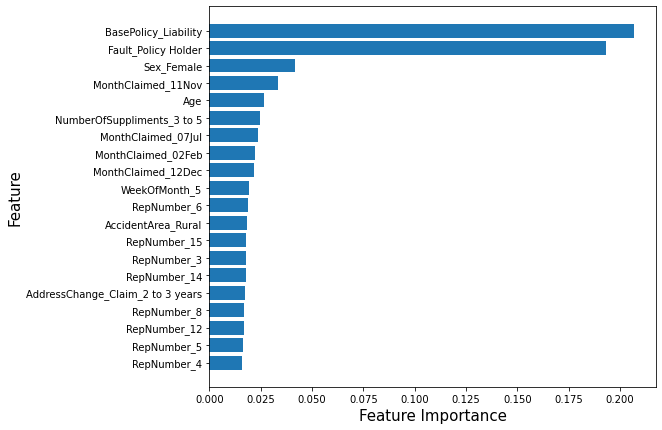

In [83]:
#show the top 20 features
fig, ax = plt.subplots(figsize=(8, 7))
ax.barh(feat_imp_df.index[:20][::-1], feat_imp_df.values[:20][::-1])
ax.set_xlabel("Feature Importance", size=15)
ax.set_ylabel("Feature", size=15)

----
### Model Interpretation using SHAP
#### Global Interpretation

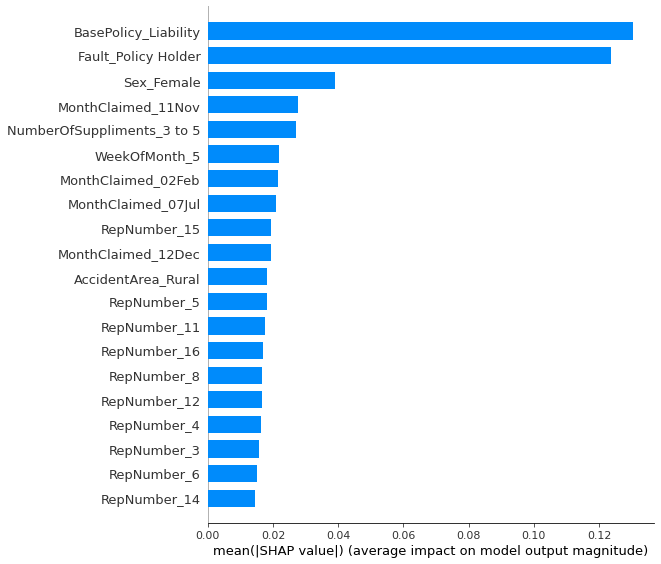

In [120]:
X_train = train_df[features].reset_index(drop=True)

shap_explainer = sh.TreeExplainer(best_model)
shap_values = shap_explainer.shap_values(X_train)[1]
sh.summary_plot(shap_values, X_train, plot_type="bar")

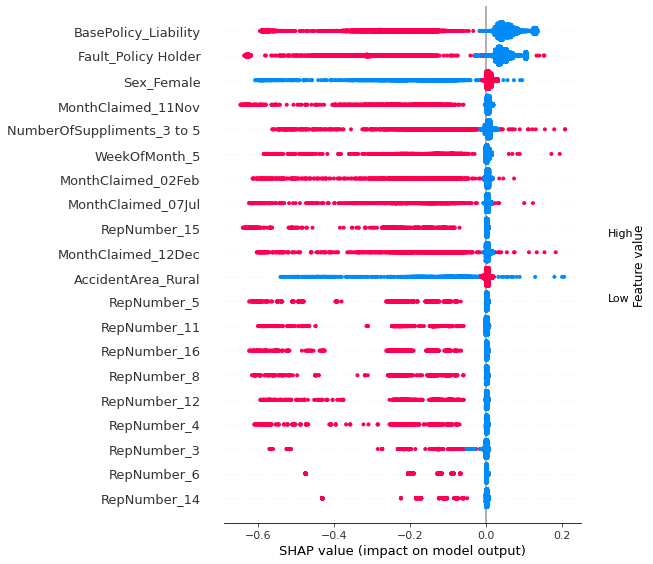

In [121]:
shap.summary_plot(shap_values, X_train)

#### Local Interpretation

In [106]:
index = 0 
sh.force_plot(shap_explainer.expected_value, 
              shap_values[index], 
              X_train.iloc[[index]])

In [107]:
index = 1
sh.force_plot(shap_explainer.expected_value, 
              shap_values[index], 
              X_train.iloc[[index]])

In [119]:
index = 53
sh.force_plot(shap_explainer.expected_value, 
              shap_values[index], 
              X_train.iloc[[index]])